In [1]:
!date

Tue Jan 30 06:32:00 EST 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

In [3]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy.spatial.distance import pdist,squareform
from rsa_funcs import fit_rsa,make_RDM,get_triu
from tqdm import tqdm

In [4]:
analyses = [a for a in os.listdir('../scratch/') if not a.startswith('.')]
analyses = np.array(analyses)
created_date = np.array([os.stat((os.path.join('../scratch/',analysis))).st_mtime for analysis in analyses])
created_date = np.argsort(created_date)[::-1]
#analyses.sort()
analyses = analyses[created_date]

def check_done(analysis_name):
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_1')):
        n1 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_1')) if f.startswith('varexp_attmp')])
    else:
        n1 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_2')):
        n2 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_2')) if f.startswith('varexp_attmp')])
    else:
        n2 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_3')):
        n3 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_3')) if f.startswith('varexp_attmp')])
    else:
        n3 = 0
    
    print(f'{analysis_name} {n1} {n2} {n3}')

[check_done(analysis_name) for analysis_name in analyses];


CVAE-3type-N500hmmrUxrGIt 43 20 0
N200-fix-ecgLoaZUBd 46 20 0
N200-fix-AzJewVzNDC 45 20 0
N200-fix-DzsjKrsbze 42 20 0
CVAE-3type-N500pAJEYZHjYj 49 20 0
CVAE-3type-N500gYGEfcZxDC 48 20 0
CVAE-3type-N500OoREXdpler 47 20 0
CVAE-3type-N500XwLMaIGLLd 47 20 0
N200-fix-tVSrAEvqkF 48 20 0
N200-fix-eqsoMaLksq 46 20 0
CVAE-3type-N1000CuxSbTjVjA 46 20 0
CVAE-3type-N1000HNNuPmQGry 49 20 0
CVAE-3type-N1000SVJIxTdsuB 47 20 0
CVAE-3type-N1000CVtphxTUCn 46 20 0
CVAE-3type-N1000eYIilgPIHN 40 20 0
CVAE-3type-RpjbVewTkF 48 20 0
CVAE-3type-COlRaiafwG 45 20 0
CVAE-3type-rxbrpNgKNC 47 20 0
CVAE-3type-cjDXIoxZHB 46 20 0
CVAE-3type-YAjYFtDAep 44 20 0
CVAE-5type-N1000-zHXfpElhZf 48 20 0
CVAE-5type-N1000-bGwnoafftJ 46 20 0
CVAE-5type-N1000-gYdpyQdCzh 48 20 0
CVAE-5type-N1000-cleHmpYSXk 44 20 0
CVAE-5type-N1000-bCxBTltyKJ 43 20 0
2type-N1000-SsAkmZgMEg 44 20 0
2type-N1000-jgaXcHvlrU 47 20 0
2type-N1000-yVufeEzKhJ 46 20 0
2type-N1000-lNlPUEKniS 47 20 0
2type-N1000-RyexWBHBsC 45 20 0
N200-FMhdEaqiXl 91 20 0
N200-x

In [213]:
data_csv_fn = '../Data/synth-data-02.csv'
#data_csv_fn = '../Data/synth-data-02.csv'
#data_csv_fn = '../Data/synth-data-01-N500.csv'

df = pd.read_csv(data_csv_fn)
n = df.shape[0]
patient_idx = np.nonzero(df['dx'].values==1)[0]
control_idx = np.nonzero(df['dx'].values==0)[0]
subtype = df['subtype'].values[patient_idx]

rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
triu = np.triu_indices(rdm_tx_s.shape[0],1)
vec_tx_s = rdm_tx_s[triu]
vec_tx_z = rdm_tx_z[triu]

In [6]:
def get_descriptive(vec):
    vec = np.array(vec)
    #print(f'M = {vec.mean():.2f}, SD = {vec.std():.2f}, range {vec.min():.2f}-{vec.max():.2f}')
    print(f'M = {np.nanmean(vec):.2f}, SD = {np.nanstd(vec):.2f}, range {np.nanmin(vec):.2f}-{np.nanmax(vec):.2f}')

In [7]:
def pretty_t_1sample(vec,popmean):
    from scipy.stats import ttest_1samp
    t,p = ttest_1samp(vec,popmean,alternative='two-sided')
    if p < .001:
        print(f't({len(vec)-1}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec)-1}) = {t:.2f}, p = {p:.3f}')

In [8]:
def pretty_t_ind(vec1,vec2):
    from scipy.stats import ttest_ind
    t,p = ttest_ind(vec1,vec2)
    if p < .001:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

In [9]:
def plot_scatters(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    
    plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    for r in range(s_latents.shape[0]):
        plt.subplot(1,s_latents.shape[0],r+1)
        for i in range(n_subtypes):
            plt.scatter(pc_comps[r][subtype_5==i+1,0],pc_comps[r][subtype_5==i+1,1],color=np.array(colors[i])/255)
        plt.title(f'repetition {r+1}')
        plt.legend(np.unique(subtype_5))


def plot_scatter(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    #pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]
    pc_comps = PCA(n_components=2).fit_transform(s_latents[0,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) )

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
    
    #plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    plt.figure(figsize=(5,5))
    r = 0
    #for r in range(s_latents.shape[0]):
    #plt.subplot(1,s_latents.shape[0],r+1)
    for i in range(n_subtypes):
        plt.scatter(pc_comps[subtype_5==i+1,0],pc_comps[subtype_5==i+1,1],color=np.array(colors[i])/255)
    #plt.title(f'repetition {r+1}')
    plt.legend(np.unique(subtype_5))
    plt.xlabel('PC 1 (a.u)')
    plt.ylabel('PC 2 (a.u)')

In [10]:
from numpy import arctanh as fisher_z # https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau

def fit_rsa(rdm_data,rdm_model,metric='kendalltau'):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)

    if metric=='kendalltau':
        #print('metric==kendalltau') 
        return kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif metric=='pearsonr':
        #print('metric==pearsonr') 
        return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    else:
        print('not implemented, wtf')
        return np.nan
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec

from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def get_clustering_acc(mat,subtype,n_components=2):
    c_ = GaussianMixture(n_components=n_components).fit_predict(mat)
    return adjusted_rand_score(c_,subtype)

In [11]:
#analyses = ['VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr','VAE_uHobWzHSMC','VAE_xxVLVwfNvW',]
analyses = ['VAE_uHobWzHSMC','VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr']
#analyses = ['VAE_TZhLdgkcdn','VAE_2type_dqgHKSXDPB','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr','VAE_2type_zEETSowiEi']

vae_varexps = []
vae_varexps_m = []
latents = []

#analysis = analyses[0]
for analysis in analyses:
    training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
    training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
    varexp = [training_log['varExps'][-1] for training_log in training_logs]
    varexp = np.array(varexp)
    
    vae_varexps.append( varexp )
    vae_varexps_m.append( varexp.mean() )
    latents.append( [training_log['l_patients'] for training_log in training_logs] )

latents = np.array(latents)
vae_varexps = np.array(vae_varexps)
vae_varexps_m = np.array(vae_varexps)

vae_c_acc_indiv = []
for i in range( latents.shape[0] ):
        vae_c_acc_indiv.append( [get_clustering_acc(latents[i,j,:,:],subtype) for j in range( latents.shape[1] )])
vae_c_acc_indiv = np.array(vae_c_acc_indiv)

vae_features_stacked = np.array([np.hstack([latents[j,i,:,:] for i in range(latents.shape[1])]) for j in range(latents.shape[0])])
vae_c_acc_ens = [get_clustering_acc(vae_features_stacked[i,:,:],subtype) for i in range(vae_features_stacked.shape[0])]

res_vae = {}
res_vae['latents'] = latents
res_vae['latents_stacked'] = vae_features_stacked
res_vae['varexps'] = vae_varexps
res_vae['varexps_m'] = vae_varexps_m
res_vae['c_acc_indiv'] = vae_c_acc_indiv
res_vae['c_acc_ens'] = np.array(vae_c_acc_ens)

[print(f'{key} | {res_vae[key].shape}') for key in list(res_vae.keys())];

latents | (5, 18, 1000, 4)
latents_stacked | (5, 1000, 72)
varexps | (5, 18)
varexps_m | (5, 18)
c_acc_indiv | (5, 18)
c_acc_ens | (5,)


In [193]:
get_descriptive(res_vae['c_acc_indiv'])

M = 0.21, SD = 0.22, range -0.00-0.83


In [13]:
get_descriptive(res_vae['c_acc_ens'])

M = 0.09, SD = 0.01, range 0.08-0.11


In [14]:
get_descriptive(res_vae['c_acc_ens'])

M = 0.09, SD = 0.01, range 0.08-0.11


In [15]:
pretty_t_1sample(res_vae['c_acc_ens'],.5)

t(4) = -79.54, p < .001


In [194]:
pretty_t_1sample(fisher_z(res_vae['c_acc_ens']),0)

t(4) = 18.32, p < .001


In [195]:
res_vae['c_acc_ens']

array([0.0763605 , 0.10538052, 0.10278598, 0.09272782, 0.09272785])

In [204]:
res_vae['latents_stacked'][0,:,:].flatten()

array([-0.05725548,  0.06005133, -0.02938563, ..., -0.4546514 ,
        0.2597162 ,  0.01242587], dtype=float32)

In [235]:
#randVals = np.array([adjusted_rand_score(GaussianMixture(n_components=2).fit_predict(np.random.permutation(res_vae['latents_stacked'][0,:,:].flatten()).reshape(res_vae['latents_stacked'][0,:,:].shape)),subtype) for i in range(100)])

In [281]:
#pretty_t_ind(fisher_z(res_vae['c_acc_ens']),fisher_z(randVals))
#pretty_t_ind(fisher_z(res_vae['c_acc_ens']),fisher_z([adjusted_rand_score(subtype,np.array([np.random.choice([0,1]) for i in range(1000)])) for  j in range(100)]))

In [16]:
#analyses = ['2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-8DqULkbZtaFi','2type-QzJmjkwddT','2type-ImTsKjutaD','2type-yvdvqaCvSX',]
def get_cvae_res(analyses,data_csv_fn = '../Data/synth-data-02.csv'):
    #data_csv_fn = '../Data/synth-data-02.csv'
    #data_csv_fn = '../Data/synth-data-01-N500.csv'
    
    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    subtype = df['subtype'].values[patient_idx]
    n_subtypes = len(np.unique(subtype))
    print(n_subtypes)
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    s_latents = []
    z_latents = []
    cvae_varexps = []
    cvae_varexps_m = []
    
    for analysis in analyses:
        training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
        training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
        varexp = [training_log['varExps'][-1] for training_log in training_logs]
        varexp = np.array(varexp)
        
        cvae_varexps.append( varexp )
        cvae_varexps_m.append( varexp.mean() )
        s_latents.append( [training_log['s_patients'] for training_log in training_logs] )
        z_latents.append( [training_log['z_patients'] for training_log in training_logs] )
    
    
    s_latents = np.array(s_latents)
    cvae_c_acc_indiv = []
    for i in range( s_latents.shape[0] ):
            cvae_c_acc_indiv.append( [get_clustering_acc(s_latents[i,j,-1,:,:],subtype,n_components=n_subtypes) for j in range( s_latents.shape[1] )])
    cvae_c_acc_indiv = np.array(cvae_c_acc_indiv)

    s_latents_stacked = np.array([np.hstack([s_latents[j,i,-1,:] for i in range(s_latents.shape[1])]) for j in range(s_latents.shape[0])])
    c_acc_ens = [get_clustering_acc(s_latents_stacked[i,:,:],subtype,n_components=n_subtypes) for i in range(s_latents_stacked.shape[0])]
    
    res_cvae = {}
    res_cvae['varexps'] = np.array(cvae_varexps)
    res_cvae['varexps_m'] = np.array(cvae_varexps_m)
    res_cvae['s_latents'] = np.array(s_latents)
    res_cvae['z_latents'] = np.array(z_latents)
    res_cvae['c_acc_indiv'] = np.array(cvae_c_acc_indiv)
    #res_cvae['c_acc_ens'] = res_cvae['c_acc_indiv'].mean(axis=1)
    res_cvae['s_latents_stacked'] = s_latents_stacked
    res_cvae['c_acc_ens'] = np.array(c_acc_ens)
    #res_cvae[''] = 
    return res_cvae

In [17]:

res_cvae = get_cvae_res(['2type-ImTsKjutaD','2type-yvdvqaCvSX','2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-QzJmjkwddT'],data_csv_fn = '../Data/synth-data-02.csv')


2


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


In [18]:
get_descriptive(res_cvae['c_acc_indiv'])

M = 0.70, SD = 0.25, range -0.00-1.00


In [19]:
get_descriptive(res_cvae['c_acc_ens'])

M = 0.99, SD = 0.01, range 0.97-1.00


In [20]:
pretty_t_1sample(res_cvae['c_acc_ens'],0.5)

t(4) = 91.04, p < .001


In [239]:
pretty_t_1sample(res_cvae['c_acc_ens'],0.0)

t(4) = 183.26, p < .001


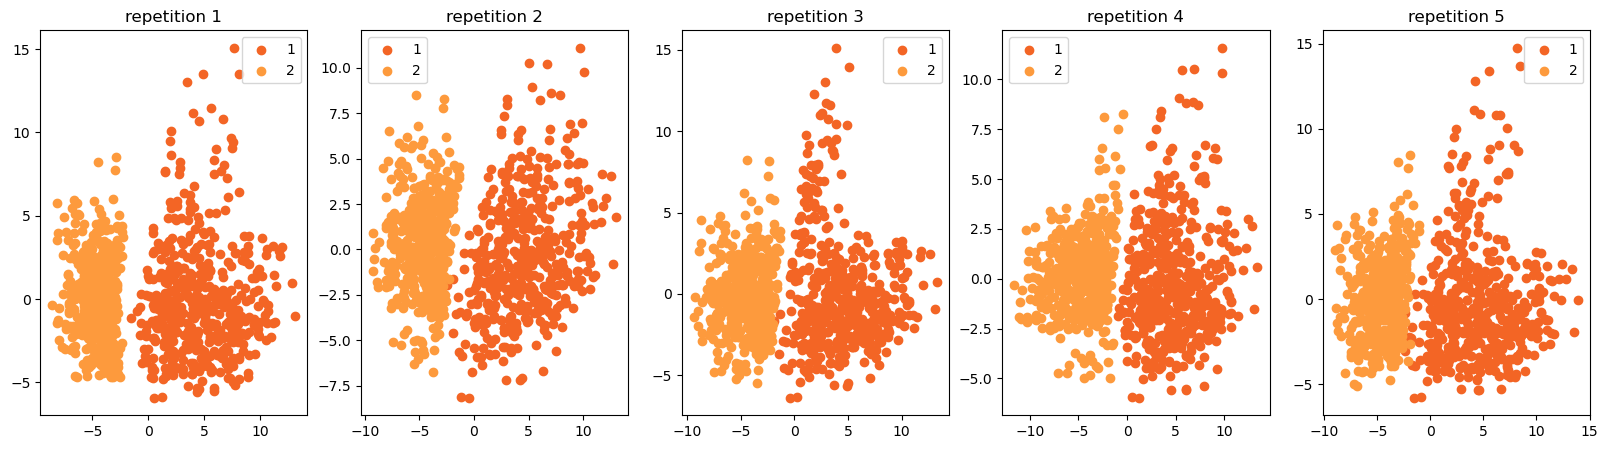

In [21]:
plot_scatters(res_cvae['s_latents'],data_csv_fn='../Data/synth-data-02.csv')

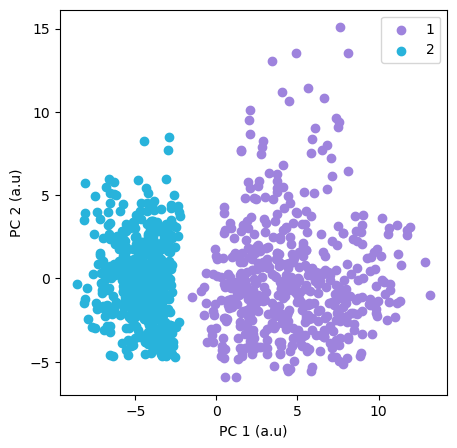

In [22]:
plot_scatter(res_cvae['s_latents'],data_csv_fn='../Data/synth-data-02.csv')

In [23]:
#plot_scatter(res_vae['latents'],data_csv_fn='../Data/synth-data-02.csv')

In [191]:

res_cvae_N1000 = get_cvae_res( ['2type-N1000-SsAkmZgMEg','2type-N1000-jgaXcHvlrU','2type-N1000-yVufeEzKhJ','2type-N1000-lNlPUEKniS','2type-N1000-RyexWBHBsC',],data_csv_fn = '../Data/synth-data-02-N1000.csv')

get_descriptive(res_cvae_N1000['c_acc_indiv'])

get_descriptive(res_cvae_N1000['c_acc_ens'])

pretty_t_1sample(res_cvae_N1000['c_acc_ens'],1/2)

pretty_t_1sample(fisher_z(res_cvae['c_acc_ens']-res_cvae_N1000['c_acc_ens']),0)

2
M = 0.58, SD = 0.23, range -0.00-1.00
M = 0.90, SD = 0.04, range 0.86-0.96
t(4) = 20.98, p < .001
t(4) = 5.21, p = 0.006


In [192]:
get_descriptive(res_cvae_N1000['c_acc_indiv'])

get_descriptive(res_cvae_N1000['c_acc_ens'])

pretty_t_1sample(res_cvae_N1000['c_acc_ens'],1/2)

pretty_t_1sample(fisher_z(res_cvae['c_acc_ens']-res_cvae_N1000['c_acc_ens']),0)

M = 0.58, SD = 0.23, range -0.00-1.00
M = 0.90, SD = 0.04, range 0.86-0.96
t(4) = 20.98, p < .001
t(4) = 5.21, p = 0.006


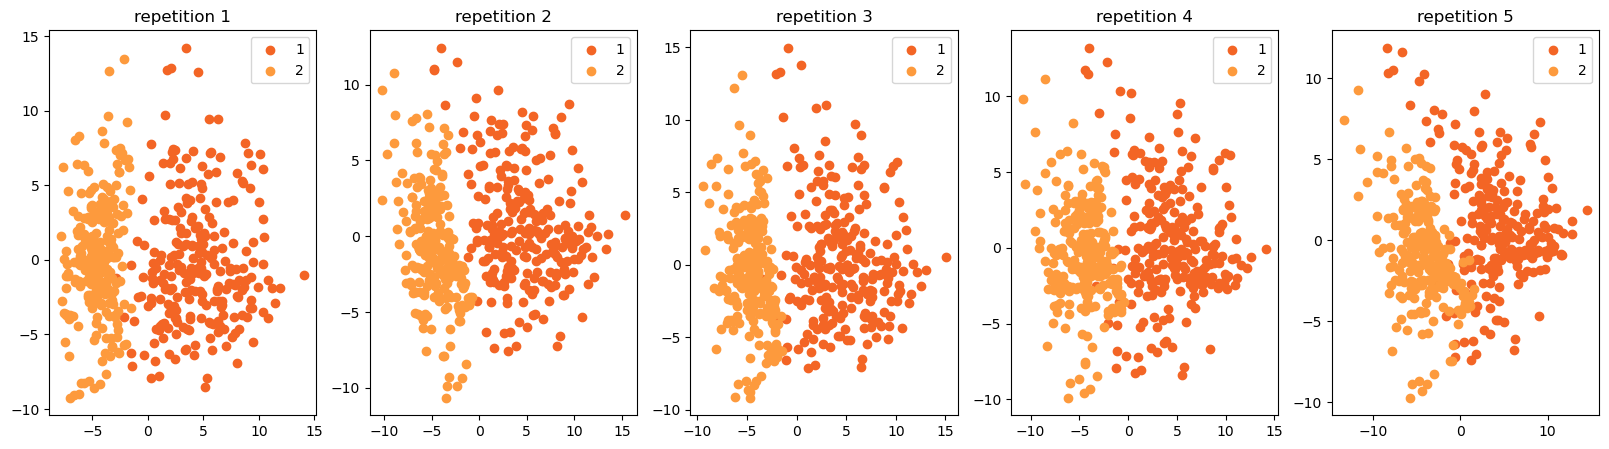

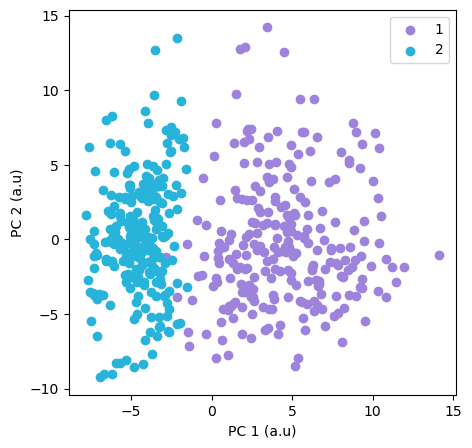

In [25]:
plot_scatters(res_cvae_N1000['s_latents'],data_csv_fn = '../Data/synth-data-02-N1000.csv')
plot_scatter(res_cvae_N1000['s_latents'],data_csv_fn = '../Data/synth-data-02-N1000.csv')

In [26]:

res_cvae_5type = get_cvae_res( ['CVAE-5type-dTkDjgdfxL','CVAE-5type-iAiIvvxnyA','CVAE-5type-HyABYkiDmv','CVAE-5type-uLtXBzUGUc','CVAE-5type-IFVZazjuWp'],data_csv_fn = '../synth-data-05/data_description.csv')


5


In [27]:
get_descriptive(res_cvae_5type['c_acc_indiv'])

M = 0.45, SD = 0.16, range 0.00-0.86


In [28]:
get_descriptive(res_cvae_5type['c_acc_ens'])

M = 0.60, SD = 0.07, range 0.51-0.69


In [29]:
pretty_t_1sample(res_cvae_5type['c_acc_ens'],1/5)

t(4) = 11.77, p < .001


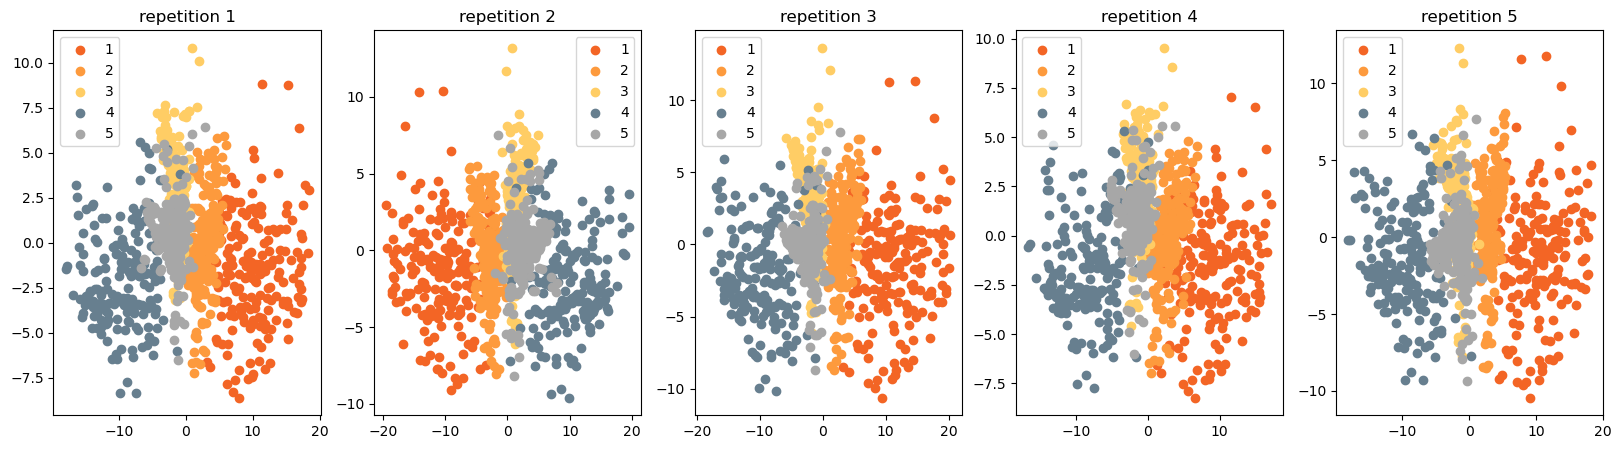

In [30]:
plot_scatters(res_cvae_5type['s_latents'],data_csv_fn='../synth-data-05/data_description.csv')

In [31]:

res_cvae_5typeN1000 = get_cvae_res(['CVAE-5type-N1000-zHXfpElhZf','CVAE-5type-N1000-bGwnoafftJ','CVAE-5type-N1000-gYdpyQdCzh','CVAE-5type-N1000-cleHmpYSXk','CVAE-5type-N1000-bCxBTltyKJ',],data_csv_fn = '../Data/synth-data-05-N1000.csv')


5


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly

In [32]:
get_descriptive(res_cvae_5typeN1000['c_acc_indiv'])

M = 0.25, SD = 0.10, range 0.00-0.47


In [33]:
get_descriptive(res_cvae_5typeN1000['c_acc_ens'])

M = 0.27, SD = 0.02, range 0.24-0.29


In [34]:
pretty_t_1sample(res_cvae_5typeN1000['c_acc_ens'],1/5)

t(4) = 8.10, p = 0.001


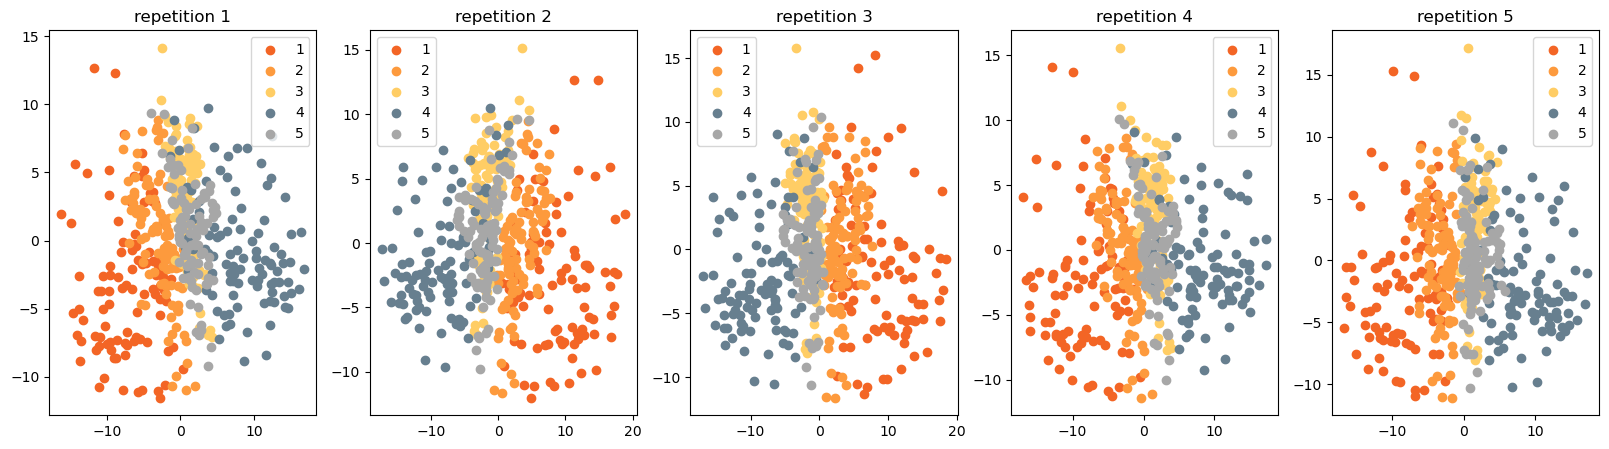

In [35]:
plot_scatters(res_cvae_5typeN1000['s_latents'],data_csv_fn='../Data/synth-data-05-N1000.csv')

In [36]:

#res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-N1000RpjbVewTkF','CVAE-3type-N1000COlRaiafwG','CVAE-3type-N1000rxbrpNgKNC','CVAE-3type-N1000cjDXIoxZHB','CVAE-3type-N1000YAjYFtDAep'],data_csv_fn = '../Data/synth-data-03-N1000.csv')
#res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-N1000HNNuPmQGry','CVAE-3type-N1000SVJIxTdsuB','CVAE-3type-N1000CVtphxTUCn','CVAE-3type-N1000eYIilgPIHN'],data_csv_fn = '../Data/synth-data-03-N1000.csv')
res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-RpjbVewTkF','CVAE-3type-COlRaiafwG','CVAE-3type-rxbrpNgKNC','CVAE-3type-cjDXIoxZHB','CVAE-3type-YAjYFtDAep'],data_csv_fn = '../synth-data-03/data_description.csv')


3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


In [37]:
res_cvae_3typeN1000['s_latents'].shape

(5, 20, 100, 1000, 2)

In [38]:
get_descriptive(res_cvae_3typeN1000['c_acc_indiv'])
get_descriptive(res_cvae_3typeN1000['c_acc_ens'])
pretty_t_1sample(res_cvae_3typeN1000['c_acc_ens'],1/3)

M = 0.72, SD = 0.16, range 0.00-0.97
M = 0.82, SD = 0.03, range 0.76-0.86
t(4) = 28.18, p < .001


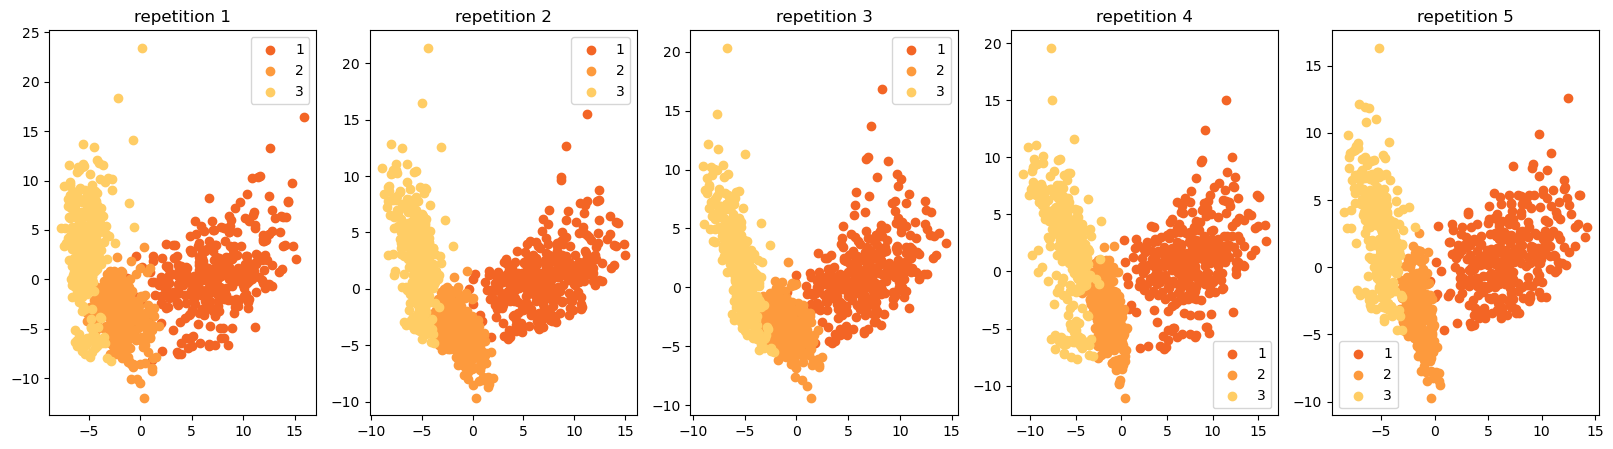

In [39]:
plot_scatters(res_cvae_3typeN1000['s_latents'],data_csv_fn='../synth-data-03/data_description.csv')

In [40]:

res_cvae_3type_N500 = get_cvae_res(['CVAE-3type-N500hmmrUxrGIt','CVAE-3type-N500pAJEYZHjYj','CVAE-3type-N500gYGEfcZxDC','CVAE-3type-N500OoREXdpler','CVAE-3type-N500XwLMaIGLLd'],data_csv_fn = '../Data/synth-data-03-N1000.csv')


3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


In [41]:
get_descriptive(res_cvae_3type_N500['c_acc_indiv'])
get_descriptive(res_cvae_3type_N500['c_acc_ens'])
pretty_t_1sample(res_cvae_3type_N500['c_acc_ens'],1/3)

M = 0.53, SD = 0.17, range 0.00-0.86
M = 0.59, SD = 0.04, range 0.54-0.67
t(4) = 11.56, p < .001


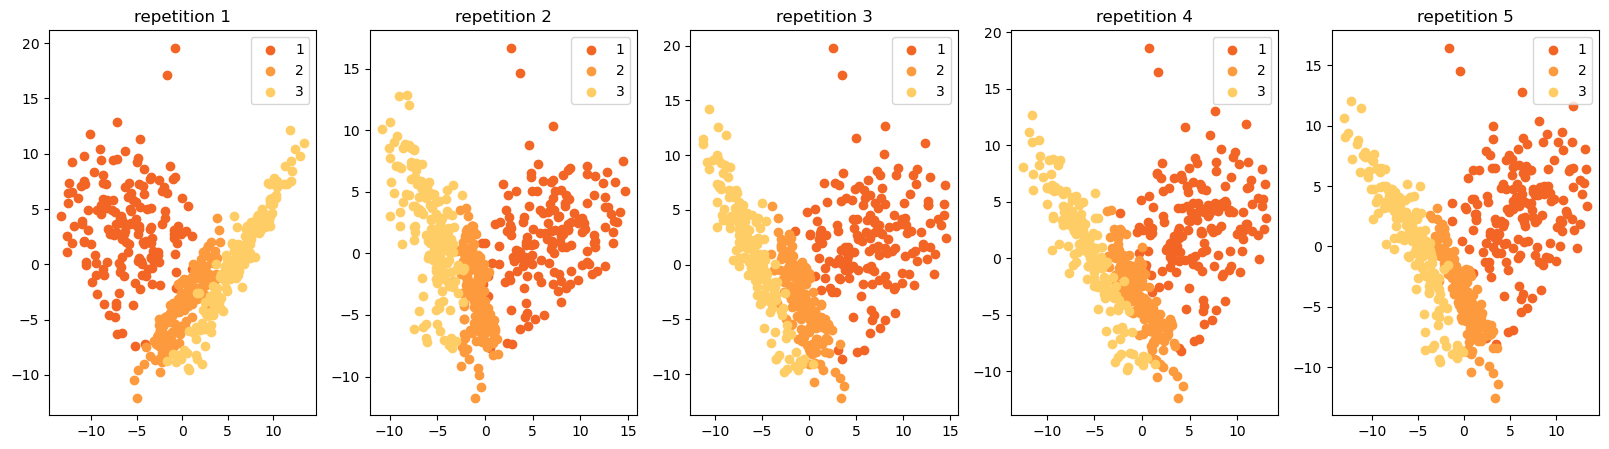

In [42]:
plot_scatters(res_cvae_3type_N500['s_latents'],data_csv_fn='../Data/synth-data-03-N1000.csv')

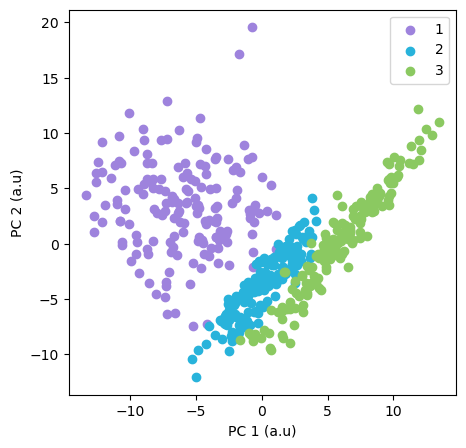

In [43]:
plot_scatter(res_cvae_3type_N500['s_latents'],data_csv_fn='../Data/synth-data-03-N1000.csv')

In [44]:
acc_cvae_2C_N1000 = res_cvae['c_acc_ens']
acc_cvae_2C_N500 = res_cvae_N1000['c_acc_ens']

acc_cvae_3C_N1000 = res_cvae_3typeN1000['c_acc_ens']
acc_cvae_3C_N500 = res_cvae_3type_N500['c_acc_ens']

acc_cvae_5C_N1000 = res_cvae_5type['c_acc_ens']
acc_cvae_5C_N500 = res_cvae_5typeN1000['c_acc_ens']

[0.9936336283509105, 0.8249751032440624, 0.5967726398805926]


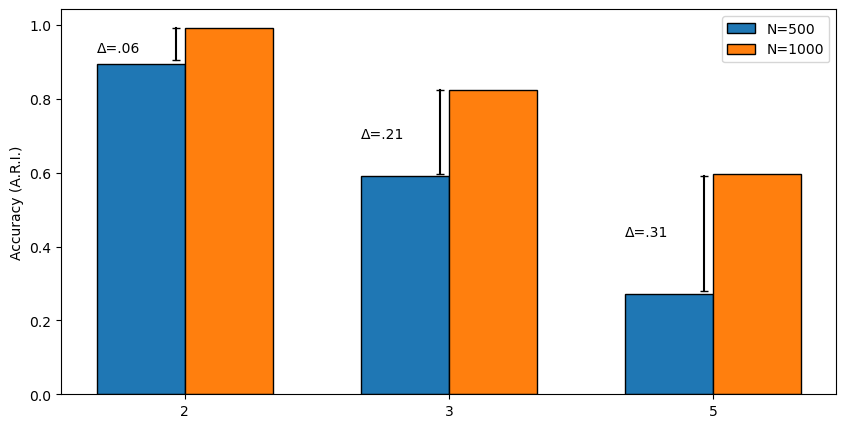

In [134]:
plt.figure(figsize=(10,5))
xs = [0,0.5, 1.5,2, 3,3.5]
#ys = [1,2,1,2,1,2]


# ys = [acc_cvae_2C_N500.mean(),
# acc_cvae_2C_N1000.mean(),
# acc_cvae_3C_N500.mean(),
# acc_cvae_3C_N1000.mean(),
# acc_cvae_5C_N500.mean(),
# acc_cvae_5C_N1000.mean()]
# plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0, 1.5, 3,]
ys = [acc_cvae_2C_N500.mean(),
acc_cvae_3C_N500.mean(),
acc_cvae_5C_N500.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0.5, 2, 3.5]
ys = [acc_cvae_2C_N1000.mean(),
acc_cvae_3C_N1000.mean(),
acc_cvae_5C_N1000.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

plt.legend(['N=500','N=1000'])

plt.plot([3.2,3.2],[acc_cvae_5C_N500.mean()*1.03,acc_cvae_5C_N1000.mean()*.99],'k-_')

delta = acc_cvae_5C_N500.mean()*1.03-acc_cvae_5C_N1000.mean()*.99
plt.text(2.75,acc_cvae_5C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.plot([0.2,0.2],[acc_cvae_2C_N500.mean()*1.01,acc_cvae_2C_N1000.mean()*1.0],'k-_')
delta = acc_cvae_2C_N500.mean()*1.03-acc_cvae_2C_N1000.mean()*.99
plt.text(-.25,acc_cvae_2C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.plot([1.7,1.7],[acc_cvae_3C_N500.mean()*1.01,acc_cvae_3C_N1000.mean()*1.0],'k-_')
delta = acc_cvae_3C_N500.mean()*1.03-acc_cvae_3C_N1000.mean()*.99
plt.text(1.25,acc_cvae_3C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))


plt.xticks([.25,1.75,3.25],labels=['2','3','5'])
plt.ylabel('Accuracy (A.R.I.)')

print(ys)

In [46]:
data = np.load('../Data/synth-data-02.npy').astype(np.float16)
df2 = pd.read_csv('../Data/synth-data-02.csv')
data.shape

(2000, 64, 64, 64)

In [47]:
patients2 = df2['dx'].values==1
controls2 = df2['dx'].values==0
subtype2 = df2['subtype'].values[patients2]

In [48]:
gt_diff = data[patients2,:,:,:]-data[controls2,:,:,:]

In [49]:
gt_subtype1 = gt_diff[subtype2==1,:,:,:].mean(axis=0).astype(np.float32)
gt_subtype2 = gt_diff[subtype2==2,:,:,:].mean(axis=0).astype(np.float32)

In [50]:
def plot_brain(mat):
    #mat = mat-mat[0,0,0]
    #mat = (mat-mat.min()) / (mat.max()-mat.min())
    #mat = (mat-mat.mean()) / mat.std()
    #vmin = mat.min()*.25
    #vmax = mat.max()*.75
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    #print((mat.min(),mat.max()))
    #print(mat[0,0,0])
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1);plt.imshow(np.rot90(mat[:,:,32]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,2);plt.imshow(np.rot90(mat[:,32,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,3);plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)

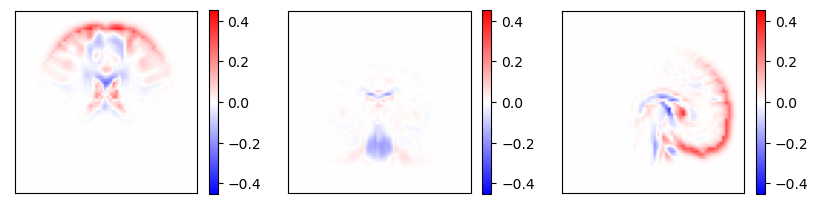

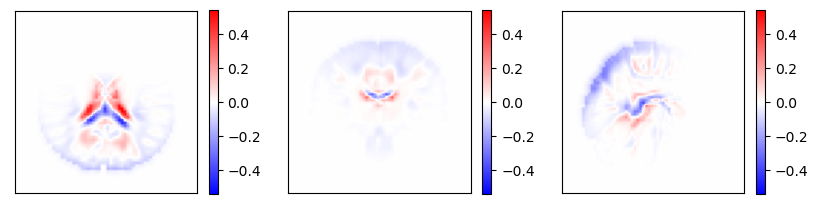

In [51]:
plot_brain(gt_subtype1)
plot_brain(gt_subtype2)

In [52]:
vae_c = GaussianMixture(n_components=2).fit_predict(res_vae['latents_stacked'][0,:,:])

In [53]:
vae_subtype1 = data[patients2,:,:,:].mean(axis=0)-data[patients2,:,:,:][vae_c==0,:,:,:].mean(axis=0)
vae_subtype2 = data[patients2,:,:,:].mean(axis=0)-data[patients2,:,:,:][vae_c==1,:,:,:].mean(axis=0)

In [54]:
vae_subtype1 = vae_subtype1.astype(np.float32)
vae_subtype2 = vae_subtype2.astype(np.float32)

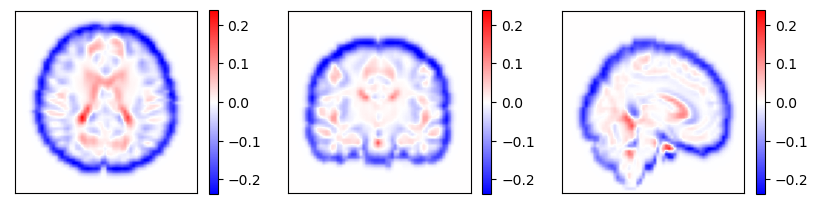

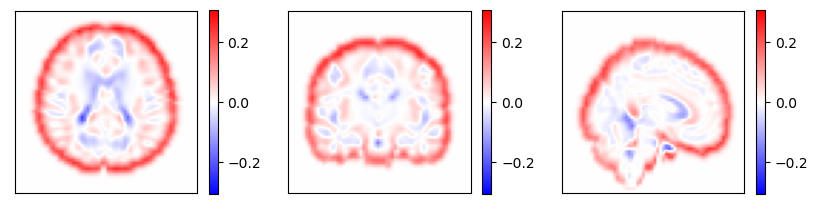

In [55]:
plot_brain(vae_subtype1)
plot_brain(vae_subtype2)

In [56]:
def get_corr_w_gt(mat1):
    #mat1=vae_subtype1
    mat2=gt_subtype1
    mat3=gt_subtype2
    mat = np.vstack( (mat1.flatten() , mat2.flatten() , mat3.flatten() ) )
    idx = (abs(mat)<.001).sum(axis=0)==0
    
    r1 = np.corrcoef(mat[0,idx],mat[1,idx])[0,1]
    r2 = np.corrcoef(mat[0,idx],mat[2,idx])[0,1]
    
    return max((r1,r2))

In [57]:
vae_sim_to_gt_subtype1 = []
vae_sim_to_gt_subtype2 = []

for i in tqdm(range(5)):
    vae_c = GaussianMixture(n_components=2).fit_predict(res_vae['latents_stacked'][i,:,:])
    vae_subtype1 = data[patients2,:,:,:].mean(axis=0)-data[patients2,:,:,:][vae_c==0,:,:,:].mean(axis=0)
    vae_subtype2 = data[patients2,:,:,:].mean(axis=0)-data[patients2,:,:,:][vae_c==1,:,:,:].mean(axis=0)
    vae_subtype1 = vae_subtype1.astype(np.float32)
    vae_subtype2 = vae_subtype2.astype(np.float32)
    vae_sim_to_gt_subtype1.append( get_corr_w_gt(vae_subtype1) )
    vae_sim_to_gt_subtype2.append( get_corr_w_gt(vae_subtype2) )
vae_sim_to_gt_subtype1 = np.array(vae_sim_to_gt_subtype1)
vae_sim_to_gt_subtype2 = np.array(vae_sim_to_gt_subtype2)

100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


In [58]:
vae_sim_to_gt_subtype1

array([0.22186074, 0.17806556, 0.22422537, 0.1655628 , 0.21886987])

In [59]:
vae_sim_to_gt_subtype2

array([0.16701544, 0.2421572 , 0.17304646, 0.22238403, 0.17086616])

In [60]:
#del data

In [61]:
# cvae_diffs = np.load('../Data/CVAE_diffs_mean.npy')
# cvae_diffs.shape

In [62]:
del data

In [63]:
def get_diff(e):
    diff = np.zeros((1000,64,64,64))
    c = 0
    for m in tqdm(range(20)):
        c = c+1
        twin = np.load(f'../Data/recons_CVAE/ens-{e}-model-{m}-twins.npy')
        recon = np.load(f'../Data/recons_CVAE/ens-{e}-model-{m}-recons.npy')
        diff=diff+(recon-twin)
    diff = diff/c
    return diff


calc_or_load = 'load'    
if calc_or_load=='calc':
    diffs = np.array([get_diff(e) for e in tqdm(range(5))])
    np.save('../Data/cvae_diffs_final.npy',diffs.astype(np.float16))
else:
    diffs = np.load('../Data/cvae_diffs_final.npy')

In [64]:
cvae_c = GaussianMixture(n_components=2).fit_predict(res_cvae['s_latents_stacked'][0,:,:])

In [65]:
cvae_subtype1 = diffs[0,cvae_c==0,:,:,:].mean(axis=0).astype(np.float32)
cvae_subtype2 = diffs[0,cvae_c==1,:,:,:].mean(axis=0).astype(np.float32)

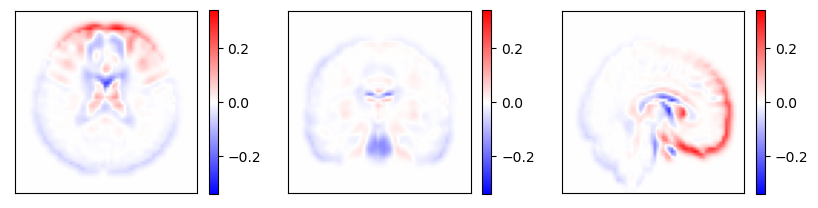

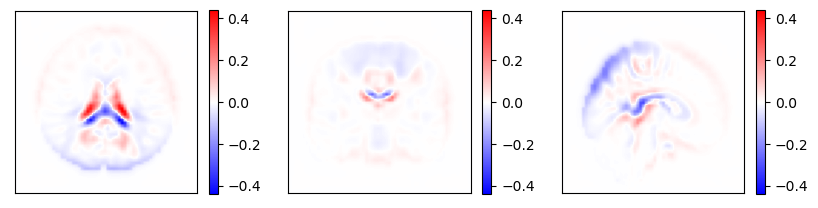

In [66]:
plot_brain(cvae_subtype1)
plot_brain(cvae_subtype2)

In [67]:
cvae_sim_to_gt_subtype1 = []
cvae_sim_to_gt_subtype2 = []

for i in tqdm(range(5)):
    cvae_c = GaussianMixture(n_components=2).fit_predict(res_cvae['s_latents_stacked'][i,:,:])
    cvae_subtype1 = diffs[i,cvae_c==0,:,:,:].mean(axis=0)
    cvae_subtype2 = diffs[i,cvae_c==1,:,:,:].mean(axis=0)
    cvae_sim_to_gt_subtype1.append( get_corr_w_gt(cvae_subtype1) )
    cvae_sim_to_gt_subtype2.append( get_corr_w_gt(cvae_subtype2) )
cvae_sim_to_gt_subtype1 = np.array(cvae_sim_to_gt_subtype1)
cvae_sim_to_gt_subtype2 = np.array(cvae_sim_to_gt_subtype2)

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


In [68]:
cvae_sim_to_gt_subtype1

array([0.92767846, 0.92838421, 0.93052853, 0.89937357, 0.92363079])

In [69]:
cvae_sim_to_gt_subtype2

array([0.90439066, 0.89707742, 0.88454166, 0.93298118, 0.89755451])

In [70]:
vae_sim_to_gt_subtype1

array([0.22186074, 0.17806556, 0.22422537, 0.1655628 , 0.21886987])

In [71]:
vae_sim_to_gt_subtype2

array([0.16701544, 0.2421572 , 0.17304646, 0.22238403, 0.17086616])

In [72]:
v1 = np.vstack((vae_sim_to_gt_subtype1,vae_sim_to_gt_subtype2)).mean(axis=0)

v2 = np.vstack((cvae_sim_to_gt_subtype1,cvae_sim_to_gt_subtype2)).mean(axis=0)

In [73]:
pretty_t_ind(fisher_z(v2),fisher_z(v1))

t(8) = 130.16, p < .001


In [74]:
del diffs

In [75]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [76]:
df = pd.read_csv('../synth-data-05/data_description.csv')
patients = df['dx'].values==1
controls = df['dx'].values==0
subtype = df.iloc[patients]['subtype'].values
isubtypes = np.unique(subtype)
nsubtypes = len(isubtypes)

In [77]:
#df = pd.read_csv('../synth-data-05/data_description.csv')
data = np.load('../synth-data-05/data.npy').astype(np.float16)
print(data.shape)
print(df.shape)

(2000, 64, 64, 64)
(2000, 13)


In [78]:
gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]

In [79]:
gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])

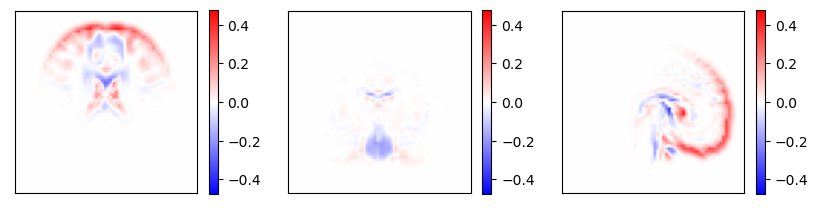

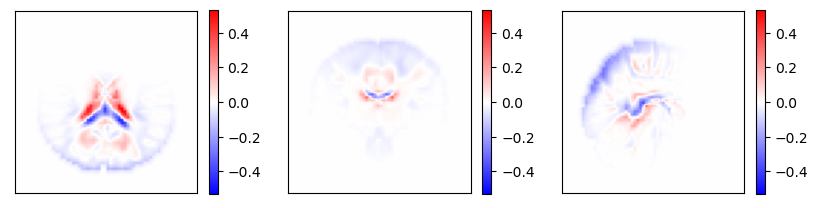

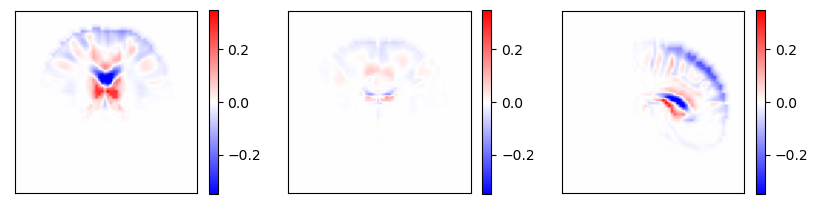

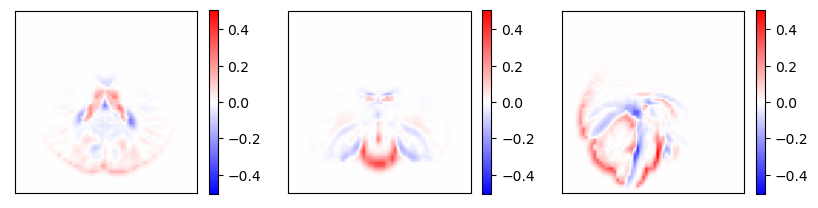

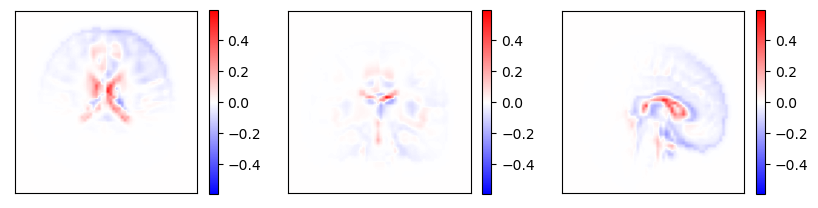

In [80]:
for i in range(nsubtypes):
    plot_brain(gt_subtypes[i,:,:,:])

In [110]:
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float32)
print(diffs.shape)

(1000, 64, 64, 64)


In [111]:
cvae_c = GaussianMixture(n_components=5).fit_predict(res_cvae_5type['s_latents_stacked'][0,:,:])

In [112]:
cvae_subtpyes = np.array([diffs[cvae_c==i,:,:,:].mean(axis=0) for i in np.unique(cvae_c)])

In [113]:
import itertools
permutations = np.array(list(itertools.permutations([0,1,2,3,4])))

In [114]:
perm1 = np.array([0,1,2,3,4])
perm2 = np.array([0,1,2,3,4])

In [115]:
def get_perm_corr(perm1,perm2):
    corrs = np.array([np.corrcoef(gt_subtypes[perm1[i],:,:,:].flatten(),cvae_subtpyes[perm2[i],:,:,:].flatten())[0,1] for i in range(len(perm1))])
    corr_avg = corrs.mean()
    return corr_avg,corrs
    #return corrs

In [116]:
corr_vec = np.array([get_perm_corr(perm1,permutations[i,:])[0] for i in range(len(permutations))])

In [117]:
cvae_subtpyes_sorted = cvae_subtpyes[permutations[np.argmax(corr_vec),:],:,:,:]

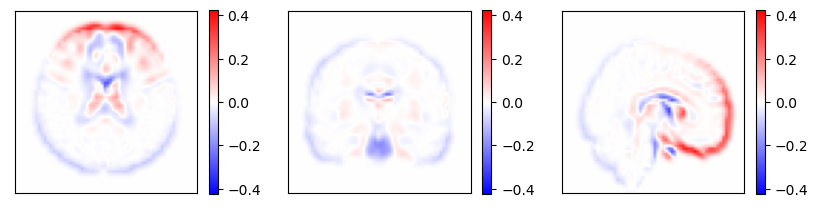

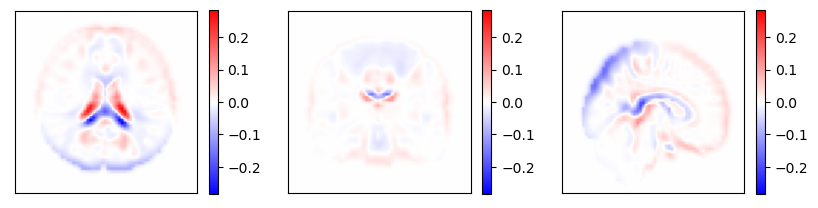

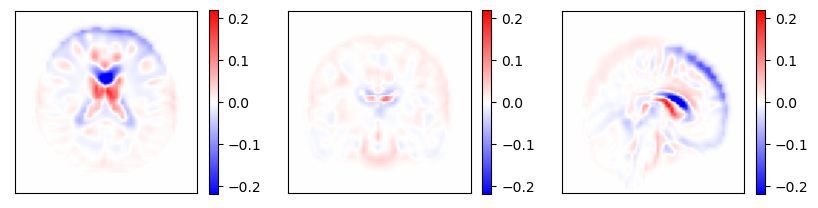

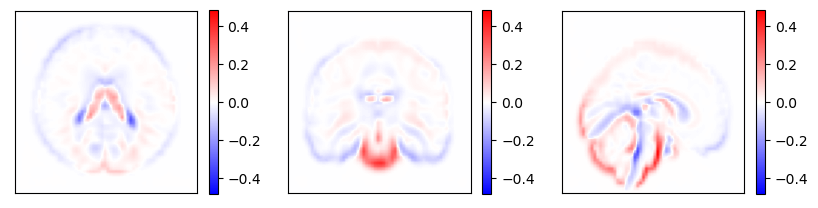

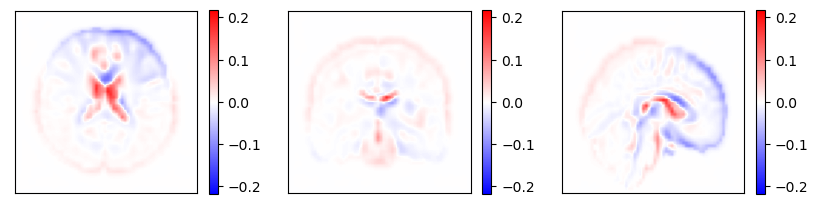

In [118]:
for i in range(nsubtypes):
    plot_brain(cvae_subtpyes_sorted[i,:,:,:])

In [119]:
get_perm_corr(perm1,permutations[np.argmax(corr_vec),:])

(0.859597646600695,
 array([0.89532549, 0.86937094, 0.89058978, 0.83199333, 0.8107087 ]))

In [91]:
del data
del diffs

In [131]:
for i in range(5):
    mat = cvae_subtpyes_sorted[i,:,:,:]
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([])#;plt.colorbar(shrink=.48)
    plt.title(i+1)
    plt.savefig(f'../Figures/NeuroSuntypes/CVAE_5_subtype_{i+1}.png',bbox_inches='tight')
    plt.close()

In [132]:
for i in range(5):
    mat = gt_subtypes[i,:,:,:]
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([])#;plt.colorbar(shrink=.48)
    plt.title(i+1)
    plt.savefig(f'../Figures/NeuroSuntypes/GT_5_subtype_{i+1}.png',bbox_inches='tight')
    plt.close()

In [136]:
#del data

In [137]:
del diffs

In [138]:
df = pd.read_csv('../synth-data-03/data_description.csv')
patients = df['dx'].values==1
controls = df['dx'].values==0
subtype = df.iloc[patients]['subtype'].values
isubtypes = np.unique(subtype)
nsubtypes = len(isubtypes)

In [142]:
nsubtypes

3

In [141]:
isubtypes

array([1, 2, 3])

In [139]:
#df = pd.read_csv('../synth-data-05/data_description.csv')
data = np.load('../synth-data-03/data.npy').astype(np.float16)
print(data.shape)
print(df.shape)

(2000, 64, 64, 64)
(2000, 13)


In [140]:
diffs = np.load('../Data/CVAE_diffs_mean-03.npy').astype(np.float32)
print(diffs.shape)

(1000, 64, 64, 64)


In [143]:
gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]

In [144]:
gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])

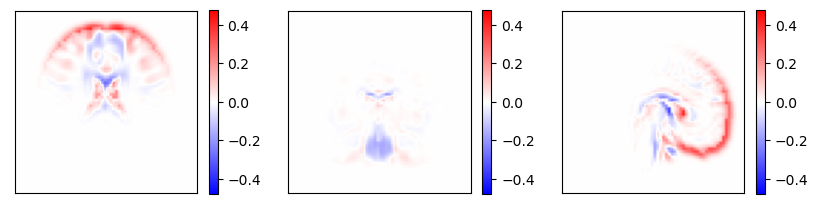

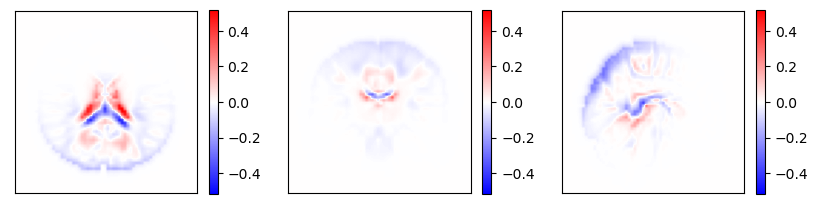

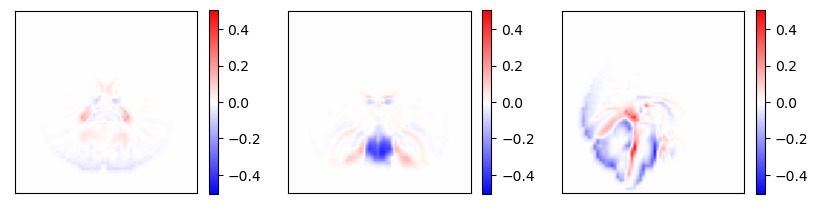

In [146]:
for i in range(nsubtypes):
    plot_brain(gt_subtypes[i,:,:,:])

In [152]:
cvae_c = GaussianMixture(n_components=3).fit_predict(res_cvae_3typeN1000['s_latents_stacked'][0,:,:])

In [153]:
cvae_subtpyes = np.array([diffs[cvae_c==i,:,:,:].mean(axis=0) for i in np.unique(cvae_c)])

In [155]:
import itertools
permutations = np.array(list(itertools.permutations(np.unique(cvae_c))))

In [171]:
perm1 = np.arange(nsubtypes)

In [159]:
corr_vec = np.array([get_perm_corr(perm1,permutations[i,:])[0] for i in range(len(permutations))])

In [172]:
get_perm_corr(perm1,permutations[np.argmax(corr_vec),:])

(0.9240599431516294, array([0.87573934, 0.92842474, 0.96801575]))

In [173]:
cvae_subtpyes_sorted = cvae_subtpyes[permutations[np.argmax(corr_vec),:],:,:,:]

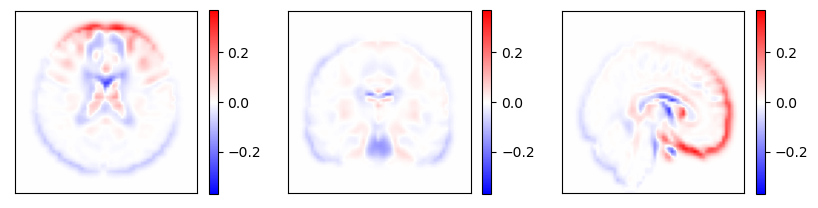

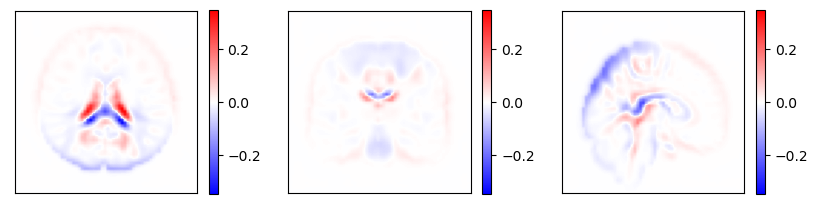

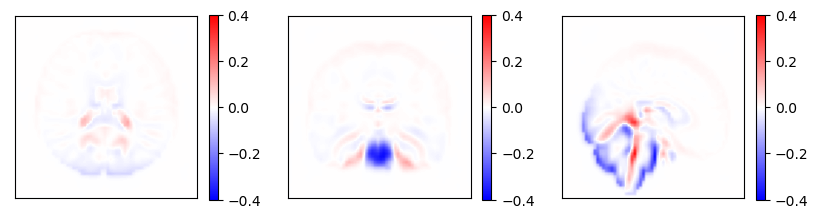

In [174]:
for i in range(nsubtypes):
    plot_brain(cvae_subtpyes_sorted[i,:,:,:])

In [184]:
# for i in range(nsubtypes):
#     plt.figure()
#     mat = cvae_subtpyes_sorted[i,:,:,:]
#     #vmin = 0-abs(mat.max())
#     #vmax = 0+abs(mat.max())
#     vmin = -0.4
#     vmax = 0.4
#     plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([])#;plt.colorbar(shrink=.48)
#     plt.title(i+1)
#     #plt.savefig(f'../Figures/NeuroSuntypes/CVAE_3_subtype_{i+1}.png',bbox_inches='tight')
#     #plt.close()

In [185]:
# for i in range(nsubtypes):
#     plt.figure()
#     mat = gt_subtypes[i,:,:,:]
#     #vmin = 0-abs(mat.max())
#     #vmax = 0+abs(mat.max())
#     vmin = -0.4
#     vmax = 0.4
#     plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([])#;plt.colorbar(shrink=.48)
#     plt.title(i+1)
#     #plt.savefig(f'../Figures/NeuroSuntypes/GT_3_subtype_{i+1}.png',bbox_inches='tight')
#     #plt.close()

In [295]:
del data

In [296]:
del diffs

In [320]:
df = pd.read_csv('../Data/synth-data-02-N1000.csv')
print(df.shape)
patients = df['dx'].values==1
controls = df['dx'].values==0
subtype = df.iloc[patients]['subtype'].values
isubtypes = np.unique(subtype)
nsubtypes = len(isubtypes)
nsubtypes

(1000, 12)


2

In [321]:
data = np.load('../Data/synth-data-02-N1000.npy')
print(data.shape)

(1000, 64, 64, 64)


In [322]:
diffs = np.load('../Data/CVAE_diffs_mean.npy')
print(diffs.shape)

(500, 64, 64, 64)


In [323]:
gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]
gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])

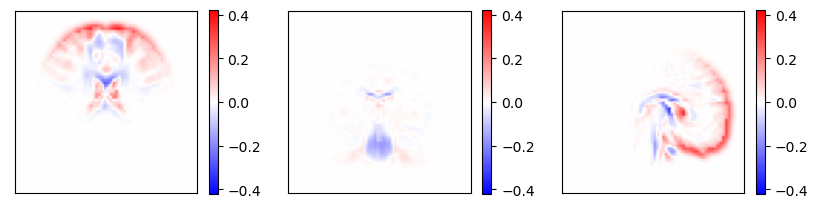

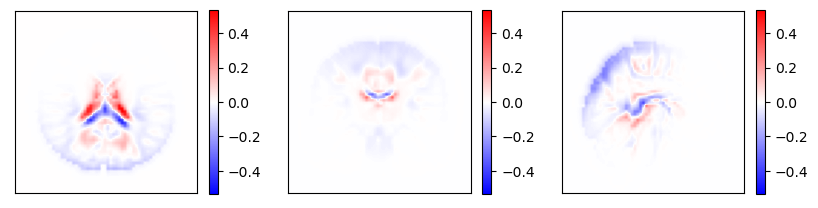

In [324]:
for i in range(nsubtypes):
    plot_brain(gt_subtypes[i,:,:,:])

In [325]:
cvae_c = GaussianMixture(n_components=nsubtypes).fit_predict(res_cvae_N1000['s_latents_stacked'][0,:,:])

In [326]:
import itertools
permutations = np.array(list(itertools.permutations(np.unique(cvae_c))))

In [327]:
perm1 = np.arange(nsubtypes)
corr_vec = np.array([get_perm_corr(perm1,permutations[i,:])[0] for i in range(len(permutations))])
get_perm_corr(perm1,permutations[np.argmax(corr_vec),:])

(0.48445747080459495, array([0.87163832, 0.09727662]))

In [328]:
cvae_subtpyes_sorted = cvae_subtpyes[permutations[np.argmax(corr_vec),:],:,:,:]

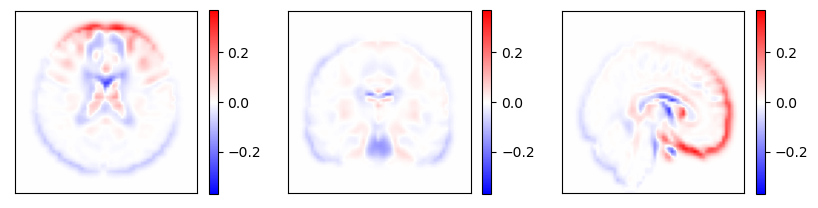

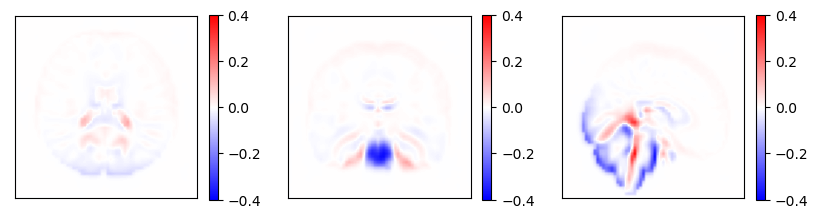

In [329]:
for i in range(nsubtypes):
    plot_brain(cvae_subtpyes_sorted[i,:,:,:])